Detect whether Weibo microblog post (Chinese) contains fake news

### Installations & Imports

Install libraries

In [ ]:
%pip install tensorflow
%pip install spacy

Load spaCy packages

In [ ]:
!python -m spacy download zh_core_web_lg
!python -m spacy download en_core_web_lg

Imports and Initializations

In [ ]:

import tensorflow as tf
import numpy as np
import pandas as pd
import json
import timeit
import spacy
import os
import re

from tensorflow import keras
from keras import layers
from keras import losses
from spacy import displacy
from spacy.language import Doc

FAKE = 1
REAL = 0
nlp = spacy.load('zh_core_web_lg')
incl_punc = False # Keep all punctuation in data


### Pre-Process Data

#### Clean Dataset Functions TODO：CONSIDER CONVERTING ALL TO SIMPLIFIED

spaCy Pad Tokens with Spaces

In [25]:
def pad_tokens(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    padded = Doc(nlp.vocab, words=tokens, spaces=([True] * len(tokens)))
    return text # padded.text

Rumors Dataset

In [26]:
def clean_rumor(data_list):
  real_ex = 0
  fake_ex = 0
  raw_text = ''

  with open('data/rumor_data/labels.txt') as f:
    labels_str = f.read()

  labels_search = re.findall('eid:(\d+)\s+label:([01])', labels_str)
  labels = dict(labels_search) # populate dictionary with post id:label pairs

  for file in os.scandir('data/rumor_data/posts/'):
    with open(file, encoding='utf-8') as f:
      json_raw = json.load(f)

    text = json_raw[0]['text']
    clean = re.sub('http:\/\/.*( |$)', '', text)
    padded = pad_tokens(clean)

    id = json_raw[0]['id']
    label = int(labels.get(str(id)))
    
    if (label == REAL):
      real_ex += 1
    else:
      fake_ex += 1
    raw_text += clean + ' '
    data_list.append([padded, label])

  return (real_ex, fake_ex, raw_text)


CHECKED Dataset

In [27]:
def clean_checked(data_list):
    real_ex = 0
    fake_ex = 0
    raw_text = ''

    # Fake news
    for file in os.scandir('data/CHECKED_data/fake_news/'):
        with open(file, encoding='utf-8') as f:
            json_raw = json.load(f)
        
        text = json_raw['text']
        clean = re.sub('(\\u200b|\\xa0|\\ue41d|\\ue627|\\u3000|\\u2005)', '', text)
        padded = pad_tokens(clean)

        fake_ex += 1
        raw_text += clean + ' '
        data_list.append([padded, FAKE])

    # Real news
    for file in os.scandir('data/CHECKED_data/real_news/'):
        with open(file, encoding='utf-8') as f:
            json_raw = json.load(f)
        
        text = json_raw['text']
        clean = re.sub('(\\u200b|\\xa0|\\ue41d|\\ue627|\\u3000|\\u2005)', '', text)
        padded = pad_tokens(clean)
        
        real_ex += 1
        raw_text += clean + ' '
        data_list.append([padded, REAL])

    return(real_ex, fake_ex, raw_text)

COVID-19 Dataset

In [28]:
def clean_covid(data_list):
  real_ex = 0
  fake_ex = 0
  raw_text = ''

  with open('data/COVID19_data/weibo_covid19_label.txt') as f:
    labels_str = f.read()

  with open('data/COVID19_data/weibo_covid19_data.txt', encoding='utf-8') as f:
    text_str = f.read()
  text_search = re.findall('(\d+)\s+None\s+\d+\s+\d+\.*\d*\s+(.+)', text_str)
  text = dict(text_search) # populate dictionary with post id:text pairs

  for (id, text) in text_search:
    labels = re.findall(f'{id}\s+([01])', labels_str)
    if (len(labels) == 0): continue
    label = labels[0]
    padded = pad_tokens(text)

    if (label == REAL):
      real_ex += 1
    else:
      fake_ex += 1
    raw_text += text + ' '
    data_list.append([padded, label])
  
  return (real_ex, fake_ex, raw_text)

Clean and Save Data

In [31]:
def clean_and_save():
    data_list = []
    
    (real_rumor, fake_rumor, raw_rumor) = clean_rumor(data_list)
    (real_checked, fake_checked, raw_checked) = clean_checked(data_list)
    (real_covid, fake_covid, raw_covid) = clean_covid(data_list)
    
    real_ex = real_rumor + real_checked + real_covid
    fake_ex = fake_rumor + fake_checked + fake_covid
    raw_text = raw_rumor + raw_checked + raw_covid

    data = pd.DataFrame(data_list, columns=['Text', 'Label'])
    data.to_csv('data/cleaned_data.csv', index=False)
    
    testj = {
        'real_ex': real_ex,
        'fake_ex': fake_ex,
        'raw_text': raw_text
    }
    with open('data/metadata.json', mode='w') as f:
      json.dump(testj, f, indent=4)

    print(f'Real Examples: {real_ex}\nFake Examples: {fake_ex}')

#### Load Data

In [32]:
if ((not os.path.exists('data/cleaned_data.csv')) or (not os.path.exists('data/metadata.json'))):
  clean_and_save()

dataset = pd.read_csv('data/cleaned_data.csv').dropna()
texts = dataset['Text'].to_numpy()
labels = dataset['Label'].to_numpy()

with open('data/metadata.json', encoding='utf-8', mode='r') as f:
  metadata = json.load(f)

real_ex = metadata['real_ex']
fake_ex = metadata['fake_ex']
raw_text = metadata['raw_text']

print(f''' 
  •=============================•
  |         DATA SUMMARY        |
  •=============================•
  | Real Examples: {real_ex}         |
  | Fake Examples: {fake_ex}         |
  | Total: {real_ex + fake_ex}                 |
  |-----------------------------|
  | Actual Size: {len(dataset)}           |
  •=============================•
''')

Real Examples: 4111
Fake Examples: 3068
 
  •=============================•
  |         DATA SUMMARY        |
  •=============================•
  | Real Examples: 4111         |
  | Fake Examples: 3068         |
  | Total: 7179                 |
  |-----------------------------|
  | Actual Size: 7176           |
  •=============================•



In [22]:


# VECTORIZING

Vectorize_layer = layers.TextVectorization()
Vectorize_layer.adapt(texts)
vocab = Vectorize_layer.get_vocabulary()
num_tokens = len(vocab)
print("num", num_tokens)

# EMBEDDING MATRIX

embedding_dim = len(nlp('曾').vector) # Finds length of arbitrary spaCy word vector 
embedding_matrix = np.zeros((num_tokens, embedding_dim))
hits, misses = 0, 0

for i, word in enumerate(vocab):
  token = nlp(word)
  if token.has_vector:
    hits += 1
    embedding_matrix[i] = token.vector
  else:
    misses += 1
print(f'hits: {hits}, misses: {misses}')

num 43883
hits: 35861, misses: 8022


In [23]:
Embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

model = tf.keras.Sequential([
    Vectorize_layer,
    Embedding_layer,
    layers.LSTM(2, return_sequences=True), # dimension size?
    layers.Dropout(0.5),
    layers.Dense(1),
    layers.Dropout(0.5),
    layers.GlobalAveragePooling1D(), # what does this do
    layers.Dropout(0.5),
    layers.Dense(1)
])

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
)

# print(model.summary())

# Train model
history = model.fit(
    texts,
    labels, # CHANGE TO NUMBERS
    batch_size = 50,
    epochs = 10,
    validation_split = 0.2 # fix to split data later
)

Epoch 1/10
115/115 [==============================] - 41s 285ms/step - loss: 0.6893 - binary_accuracy: 0.5348 - val_loss: 0.6459 - val_binary_accuracy: 0.8162
Epoch 2/10
115/115 [==============================] - 31s 268ms/step - loss: 0.6790 - binary_accuracy: 0.5605 - val_loss: 0.6384 - val_binary_accuracy: 0.8433
Epoch 3/10
115/115 [==============================] - 33s 289ms/step - loss: 0.6557 - binary_accuracy: 0.6211 - val_loss: 0.6344 - val_binary_accuracy: 0.8538
Epoch 4/10
115/115 [==============================] - 33s 291ms/step - loss: 0.6193 - binary_accuracy: 0.6444 - val_loss: 0.5616 - val_binary_accuracy: 0.7813
Epoch 5/10
115/115 [==============================] - 32s 276ms/step - loss: 0.5389 - binary_accuracy: 0.6901 - val_loss: 0.4100 - val_binary_accuracy: 0.8524
Epoch 6/10
115/115 [==============================] - 39s 341ms/step - loss: 0.5246 - binary_accuracy: 0.7035 - val_loss: 0.3755 - val_binary_accuracy: 0.8851
Epoch 7/10
115/115 [==========================

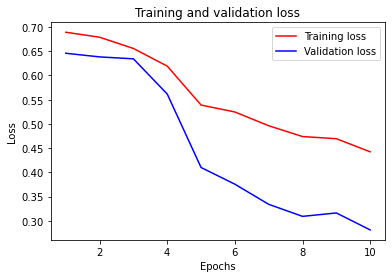

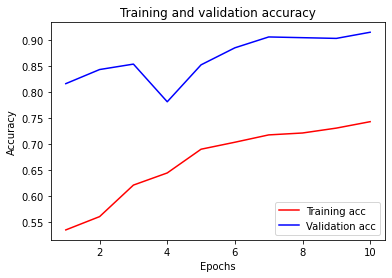

In [24]:
from matplotlib import pyplot as plt

history_dict = history.history
history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# ARCHIVE

In [19]:
#=================================#
#          PROCESS DATA           #
#=================================#

if ((not os.path.exists('data/cleaned_data.csv')) or (not os.path.exists('data/metadata.csv'))):
  clean_and_save()

dataset = pd.read_csv('data/cleaned_data.csv')
metadata = pd.read_csv('data/metadata.csv')

# VECTORIZING


Vectorize_layer = layers.TextVectorization()
Vectorize_layer.adapt(dataset.Text.to_numpy())
vocab = Vectorize_layer.get_vocabulary()
num_tokens = len(vocab)

# EMBEDDING MATRIX

embedding_dim = len(nlp('曾').vector) # Finds length of arbitrary spaCy word vector 
embedding_matrix = np.zeros((num_tokens, embedding_dim))
hits, misses = 0, 0

for i, token in enumerate(vocab):
  if token.is_oov:
    misses += 1
  else:
    embedding_matrix[i] = token.vector
    hits += 1
print(f'hits: {hits}, misses: {misses}')

Embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

sequence_length = 250
vectorize_layer = layers.TextVectorization(
    max_tokens=num_tokens,
    output_mode='int',
    output_sequence_length=sequence_length)

#=================================#
#         CREATING MODEL          #
#=================================#

# How can I use other spaCy pipeline info (e.g., NER, dependencies) in model?
model = tf.keras.Sequential([
    Vectorize_layer,
    Embedding_layer,
    layers.LSTM(2, return_sequences=True), # dimension size?
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(), # what does this do
    layers.Dense(1)
])

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
)

# print(model.summary())

# Train model
model.fit(
    posts,
    labels, # CHANGE TO NUMBERS
    batch_size = 20,
    epochs = 50,
    validation_split = 0.2 # fix to split data later
)

#=================================#
#           EVALUATING            #
#=================================#



KeyboardInterrupt: 

In [ ]:
nlp1 = spacy.load('zh_core_web_lg')
nlp2 = spacy.load('en_core_web_sm')

doc = nlp1('漂亮 美丽')
doc2 = nlp2('this is a sentence')

displacy.serve(doc2, style='dep')

# print('\t Text\t\t is_num\t\t is_stop')
# print('-'*45)
# for i, token in enumerate(doc):
#   print(f'{i}\t {token.text}\t\t {token.like_num}\t\t {token.is_stop}')

# a, b = 0, 1
# print(f'{doc[a]}, {doc[b]} similarity: {doc[a].similarity(doc[b])}')
# print(f'{doc2[a]}, {doc2[b]} similarity: {doc2[a].similarity(doc2[b])}')

In [ ]:
test = pd.read_json('data/rumor_data/posts/4010312877.json')

store = []
store.append(test.loc[0, 'text'])
print(store)
# print(one)